<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Build-function-for-building-cascade" data-toc-modified-id="Build-function-for-building-cascade-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build function for building cascade</a></span><ul class="toc-item"><li><span><a href="#Test-shortest-path-function" data-toc-modified-id="Test-shortest-path-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test shortest path function</a></span></li></ul></li><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import dataset</a></span><ul class="toc-item"><li><span><a href="#Store-cascade-data" data-toc-modified-id="Store-cascade-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Store cascade data</a></span></li><li><span><a href="#Store-cascade-seed-data" data-toc-modified-id="Store-cascade-seed-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Store cascade seed data</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Criticize-model-compared-to-NETRATE-results" data-toc-modified-id="Criticize-model-compared-to-NETRATE-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Criticize model compared to NETRATE results</a></span></li></ul></div>

In [171]:
import tensorflow as tf
import edward as ed
import numpy as np

from edward.models import Beta, Exponential, Gamma

In [50]:
sess = ed.get_session()

# Build function for building cascade

In [419]:
def build_cascade(time, seed, T):
    # Store number of nodes
    n = time.shape[0]

    # Transpose times and reduce minimum
    times_T = tf.minimum(tf.transpose(time),T)

    # Initialize transmission times to be max time except for seed node
    transmission = tf.ones(n)*T
    transmission = tf.subtract(transmission,tf.one_hot(seed, n)*T)

    
    # Continually update transmissions
    for _ in range(n):
        

        # Tile transmission
        transmission_tiled = tf.reshape(tf.tile(transmission,[n]),[n,n])

        # Add transposed times and tiled transmissions
        potential_transmission = tf.add(transmission_tiled,times_T)

        # Find minimum path from all new 
        potential_transmission_row = tf.reduce_min(potential_transmission, reduction_indices=[1])

        # Concatenate previous transmission and potential new transmission
        potential_transmission_stack = tf.stack([transmission,potential_transmission_row],axis=0)

        # Take the minimum of the original transmission and the potential new transmission
        transmission = tf.reduce_min(potential_transmission_stack, reduction_indices=[0])

    return transmission

In [433]:
def build_cascade_series(time, seeds, T):

    transmission_stack = tf.map_fn(lambda x: build_cascade(time, x, T), seeds, dtype=tf.double)
    return tf.cast(transmission_stack,tf.float64)

## Test shortest path function

In [454]:
alpha = tf.convert_to_tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                              [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],tf.float32)
tau = Exponential(alpha)

sess.run(build_cascade(tau, 2, 10))

array([10., 10.,  0., 10., 10., 10., 10., 10., 10., 10.])

# Import dataset

In [256]:
with open('kronecker-core-periphery-n1024-h10-r0_01-0_25-1000-cascades.txt','r') as f:
    
    # Store number of nodes
    numNodes = -1
    while True:
        if f.readline() == "\n":
            break
        numNodes+=1

    # Collect cascades into list
    v = []
    for line in f.readlines():
        v.append([float(l) for l in line.rstrip('\n').split(",")])

## Store cascade data

In [265]:
np_cascades = np.ones((len(v),numNodes),np.float32)*10
for row, cascade in enumerate(v):  
    c_nodes = [int(cascade[i*2]) for i in range(len(cascade)//2)]
    c_times = [cascade[i*2+1] for i in range(len(cascade)//2)]

    for col in range(len(c_nodes)):
        np_cascades[row][c_nodes[col]]=c_times[col]

## Store cascade seed data

In [472]:
np_seeds = np.array([cascade[0] for cascade in v], dtype = np.int)

753

# Model

In [482]:
# Time horizon of cascade
T = 10

# Gamma(1,1) priors on alpha
ed_a = Gamma(tf.ones([numNodes,numNodes]),tf.ones([numNodes,numNodes]))

# Exponentiate alpha to get times
ed_tau = Exponential(ed_a)

# Placeholder for seed input data
seed_ph = tf.placeholder(tf.int64, [np_seeds.shape[0],])

# Build cascade series of C cascades
cascade_ph = build_cascade_series(ed_tau, seed_ph, T)

In [483]:
data = {cascade_ph: np_cascades,
        seed_ph: np_seeds}
inference = ed.MAP([ed_a], data)

/Users/brianallen131/src/edward/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [484]:
tf.global_variables_initializer().run()

inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 95s | Loss: 399.227


In [489]:
optimized_alpha = sess.run(inference.latent_vars)

In [490]:
# Should result in 261 as its highest value..

list(optimized_alpha.values())[0][753].argsort()[::-1]


array([138, 201, 326, ...,  81, 912, 198])

In [513]:
def printCascade(cascade):
    print("order\t node\t time")
    print("-----\t ----\t ----")
    for i in range(len(cascade)//2):
        print('{:5d}\t {:4d}\t {:0.2f}'.format(i+1,int(cascade[i*2]), cascade[i*2+1]))

printCascade(v[0])

order	 node	 time
-----	 ----	 ----
    1	  753	 0.00
    2	  261	 1.35
    3	  704	 3.97
    4	  145	 4.90
    5	   73	 5.93
    6	  286	 6.63
    7	  556	 7.84
    8	   80	 8.14
    9	  458	 8.78
   10	    8	 8.79
   11	  467	 8.90
   12	  554	 8.91
   13	   53	 9.24
   14	    1	 9.45
   15	  584	 9.59
   16	  843	 9.60
   17	  116	 9.78
   18	  130	 9.82
   19	  545	 9.83
   20	  579	 9.97
   21	  535	 9.98


# Criticize model compared to NETRATE results

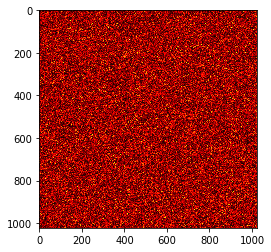

In [485]:
import matplotlib.pyplot as plt
plt.imshow(list(optimized_alpha.values())[0], cmap='hot')

In [486]:
netrate = np.loadtxt(open("netrate alpha.txt", "rb"), delimiter=",")

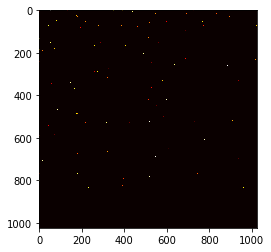

In [487]:
plt.imshow(netrate,cmap='hot')

In [488]:
netrate[753][261]

0.20747